### Importing Libraries

In [1]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

### Configuration

In [2]:
DATA_DIR = "Dataset_BUSI_with_GT"
CLASSES = {'benign': 1, 'malignant': 2, 'normal': 0}
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 50

### Downloading Data

In [3]:
def load_data(data_dir, img_size=IMG_SIZE):
    images = []
    masks = []
    for class_name, class_id in CLASSES.items():
        class_path = os.path.join(data_dir, class_name)
        for file in os.listdir(class_path):
            if "_mask" not in file:
                img_path = os.path.join(class_path, file)
                mask_path = os.path.join(class_path, file.replace(".png", "_mask.png"))
                if os.path.exists(mask_path):
                    img = load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    
                    mask = load_img(mask_path, target_size=(img_size, img_size), color_mode="grayscale")
                    mask = img_to_array(mask).astype(np.uint8)  
                    mask = np.where(mask > 0, class_id, 0)
                    masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    masks = to_categorical(masks, num_classes=len(CLASSES))

    images = np.expand_dims(images, axis=-1)
    
    return images, masks

In [4]:
images, masks = load_data(DATA_DIR)
print(f"Uploaded {len(images)} images and {len(masks)} masks.")

Uploaded 780 images and 780 masks.


### Image and Corresponding Mask Output

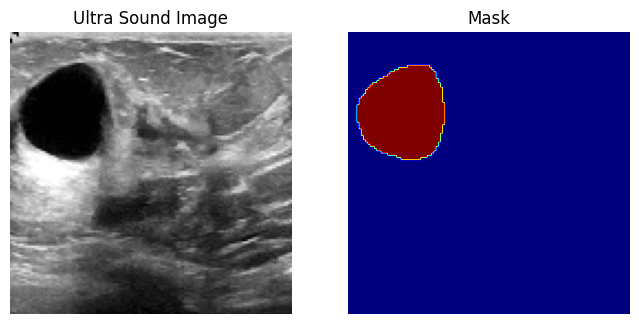

In [5]:
def display_image_and_mask(image, mask):
    plt.figure(figsize=(8, 4))

    # Image Display
    plt.subplot(1, 2, 1)
    plt.title("Ultra Sound Image")
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")

    # Mask Display
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(np.argmax(mask, axis=-1), cmap="jet")
    plt.axis("off")

    plt.show()


sample_image = images[1]  # Image
sample_mask = masks[1]  # Corresponding Mask

display_image_and_mask(sample_image, sample_mask)

### Output 5 Images from Each Category

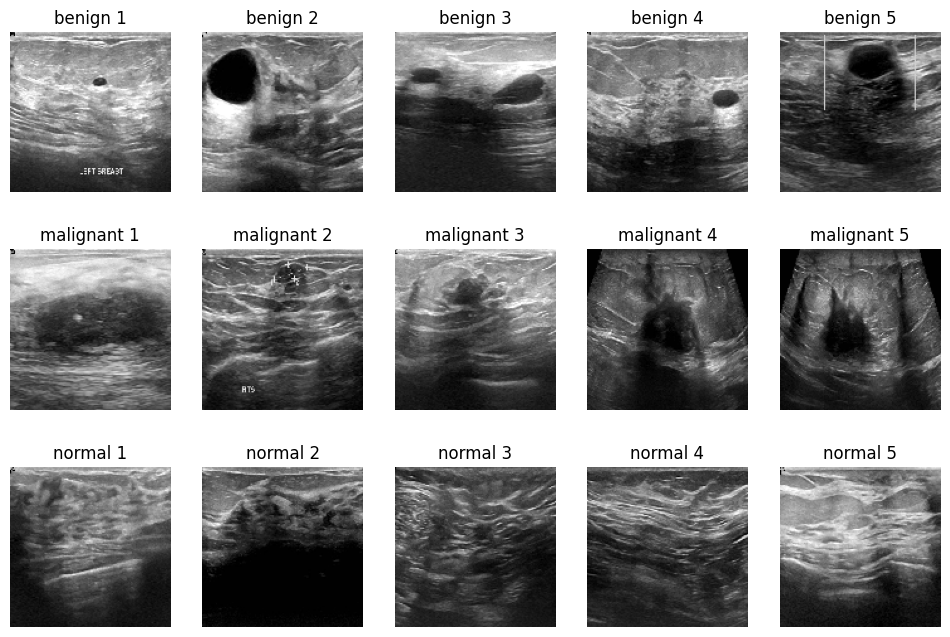

In [6]:
# Function to output 5 images from each category
def display_images_from_each_class(data_dir, classes, num_images=5):
    plt.figure(figsize=(12, 8))
    
    for idx, (class_name, class_id) in enumerate(classes.items()):
        class_path = os.path.join(data_dir, class_name)
        image_files = [file for file in os.listdir(class_path) if "_mask" not in file]
        
        # Choosing the first num_images images from each category
        selected_images = image_files[:num_images]
        
        for i, image_file in enumerate(selected_images):
            img_path = os.path.join(class_path, image_file)
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
            img = img_to_array(img) / 255.0  # Image normalization
            
            plt.subplot(len(classes), num_images, idx * num_images + i + 1)
            plt.imshow(img.squeeze(), cmap="gray")
            plt.title(f"{class_name} {i+1}")
            plt.axis("off")
    
    plt.show()

display_images_from_each_class(DATA_DIR, CLASSES, num_images=5)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.residual_conv:
            residual = self.residual_conv(residual)
        
        out += residual 
        out = self.relu(out)
        return out

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = ResidualBlock(in_channels, 32)
        self.enc2 = ResidualBlock(32, 64)
        self.enc3 = ResidualBlock(64, 128)
        self.enc4 = ResidualBlock(128, 256)
        
        self.pool = nn.MaxPool2d(2)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.dec3 = ResidualBlock(256, 128)
        self.dec2 = ResidualBlock(128, 64)
        self.dec1 = ResidualBlock(64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
    
        
        dec3 = self.dec3(torch.cat([self.upconv3(enc4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        return self.final_conv(dec1)

In [9]:
images = np.squeeze(images)

images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1) 
masks_tensor = torch.tensor(masks, dtype=torch.float32).permute(0, 3, 1, 2)

In [10]:
print(f"images_tensor shape: {images_tensor.shape}") 
print(f"masks_tensor shape: {masks_tensor.shape}")   

images_tensor shape: torch.Size([780, 1, 128, 128])
masks_tensor shape: torch.Size([780, 3, 128, 128])


In [11]:
X_train, X_val, y_train, y_val = train_test_split(images_tensor, masks_tensor, test_size=0.2, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

### Model Training

In [12]:
model = UNet(in_channels=1, out_channels=len(CLASSES))

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [14]:
# Function for calculating metrics
def compute_metrics(pred, true):
    pred = torch.argmax(pred, dim=1).cpu().numpy().flatten()
    true = torch.argmax(true, dim=1).cpu().numpy().flatten()
    
    accuracy = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average='weighted') 
    precision = precision_score(true, pred, average='weighted')
    recall = recall_score(true, pred, average='weighted')
    iou = jaccard_score(true, pred, average='weighted')
    
    return accuracy, f1, precision, recall, iou

In [15]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [16]:
for epoch in range(EPOCHS):
    model.train()

    train_loss = 0
    train_acc = 0

    for images_batch, masks_batch in train_loader:
        images_batch, masks_batch = images_batch, masks_batch
        optimizer.zero_grad()
        
        outputs = model(images_batch)
        loss = criterion(outputs, torch.argmax(masks_batch, dim=1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_metrics(outputs, masks_batch)[0]
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    val_loss = 0
    val_acc = 0

    accuracies, f1_scores, precisions, recalls, ious = [], [], [], [], []

    model.eval()
    
    with torch.no_grad():
        for images_batch, masks_batch in val_loader:
            images_batch, masks_batch = images_batch, masks_batch

            outputs = model(images_batch)
            loss = criterion(outputs, torch.argmax(masks_batch, dim=1))

            val_loss += loss.item()
            val_acc += compute_metrics(outputs, masks_batch)[0]

            acc, f1, prec, rec, iou = compute_metrics(outputs, masks_batch)

            accuracies.append(acc)
            f1_scores.append(f1)
            precisions.append(prec)
            recalls.append(rec)
            ious.append(iou)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))
        
    print(f"Epoch {epoch+1}/{EPOCHS}, Learning Loss: {train_losses[-1]:.4f}, Learning Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Validation Losses: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

Epoch 1/50, Learning Loss: 0.8244, Learning Accuracy: 0.8044
Validation Losses: 0.6582, Validation Accuracy: 0.9243
Epoch 2/50, Learning Loss: 0.5084, Learning Accuracy: 0.9298
Validation Losses: 0.4230, Validation Accuracy: 0.9262
Epoch 3/50, Learning Loss: 0.2681, Learning Accuracy: 0.9321
Validation Losses: 0.2559, Validation Accuracy: 0.9303
Epoch 4/50, Learning Loss: 0.2134, Learning Accuracy: 0.9345
Validation Losses: 0.2310, Validation Accuracy: 0.9317
Epoch 5/50, Learning Loss: 0.1900, Learning Accuracy: 0.9406
Validation Losses: 0.1962, Validation Accuracy: 0.9386
Epoch 6/50, Learning Loss: 0.1776, Learning Accuracy: 0.9435
Validation Losses: 0.2138, Validation Accuracy: 0.9292
Epoch 7/50, Learning Loss: 0.1752, Learning Accuracy: 0.9440
Validation Losses: 0.1951, Validation Accuracy: 0.9408
Epoch 8/50, Learning Loss: 0.1664, Learning Accuracy: 0.9473
Validation Losses: 0.1892, Validation Accuracy: 0.9386
Epoch 9/50, Learning Loss: 0.1613, Learning Accuracy: 0.9463
Validation 

In [17]:
print(f"Average Accuracies: {np.mean(accuracies):.4f}")
print(f"Average F1-measure: {np.mean(f1_scores):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average IoU: {np.mean(ious):.4f}")

Average Accuracies: 0.9431
Average F1-measure: 0.9274
Average Precision: 0.9362
Average Recall: 0.9431
Average IoU: 0.8968


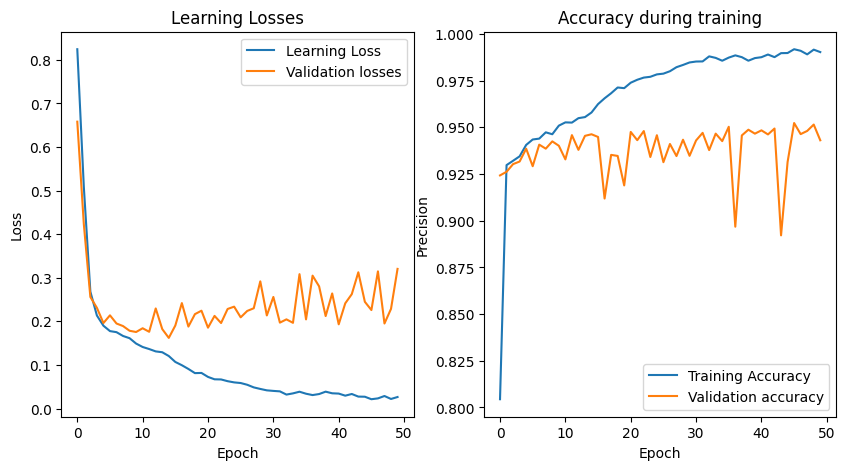

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Learning Loss")
plt.plot(val_losses, label="Validation losses")
plt.legend()
plt.title("Learning Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.legend()
plt.title("Accuracy during training")
plt.xlabel("Epoch")
plt.ylabel("Precision")

plt.show()

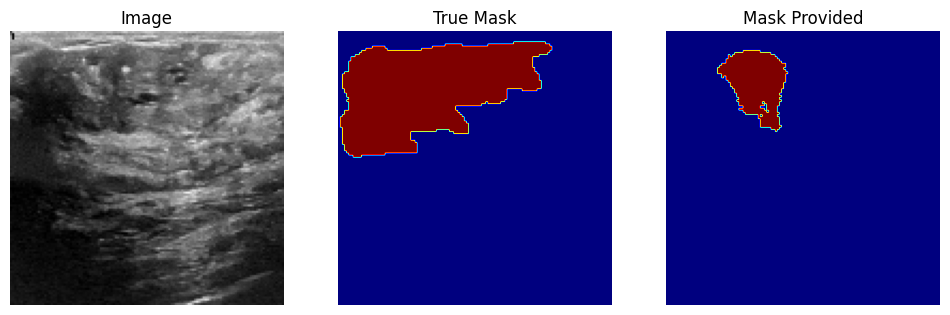

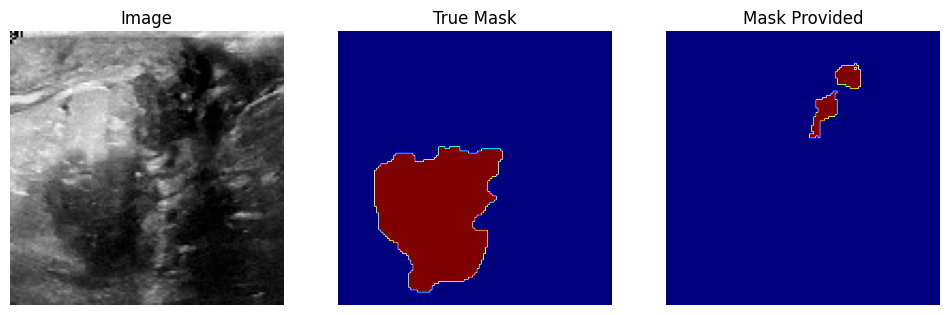

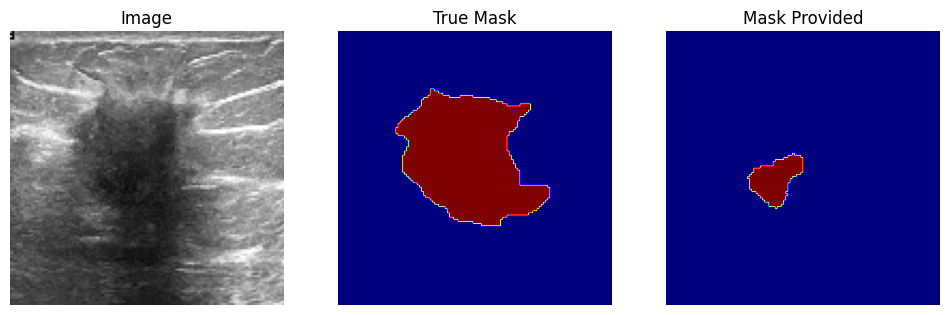

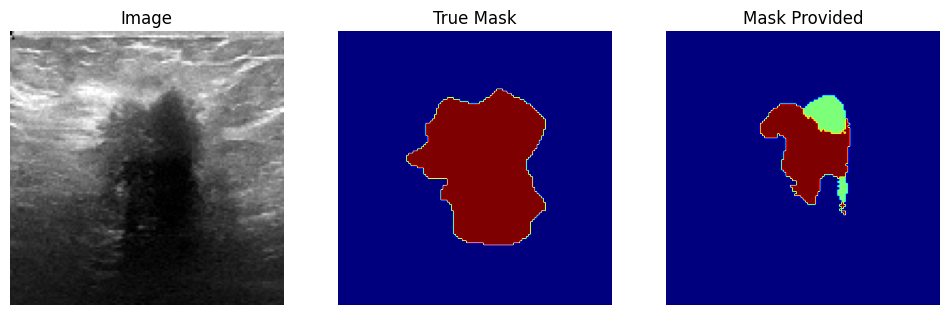

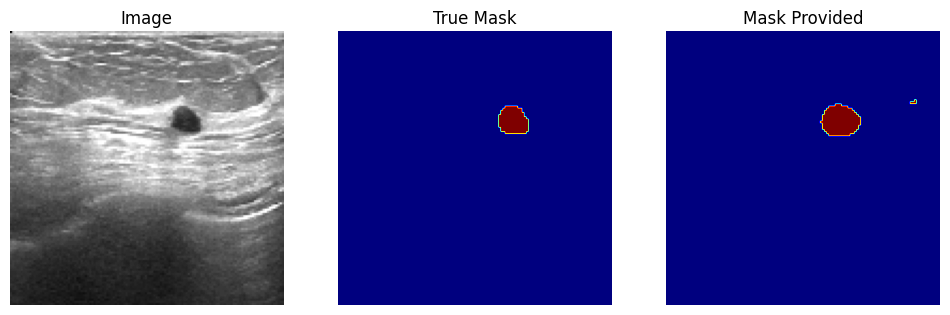

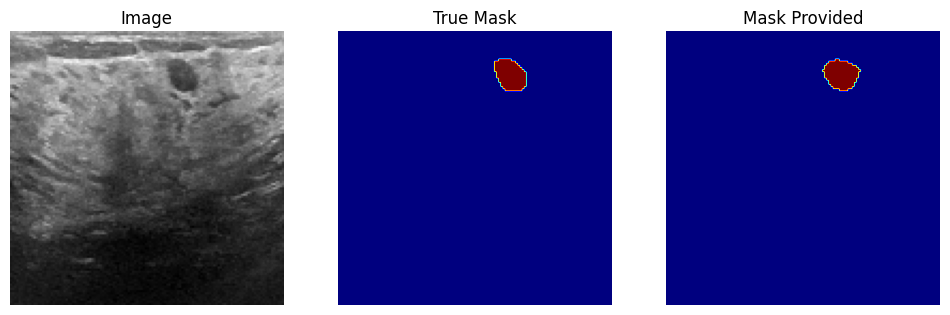

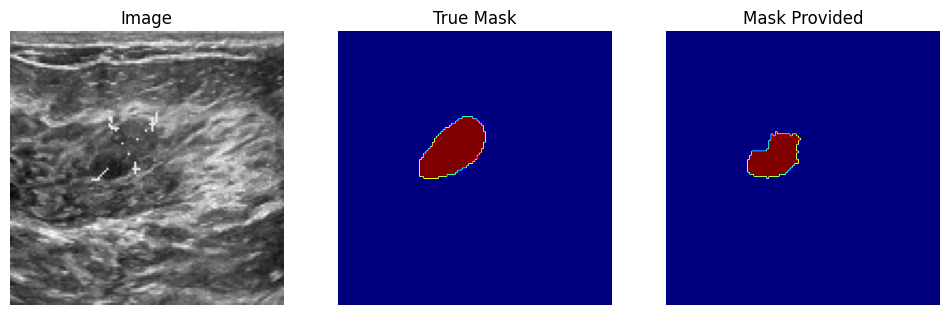

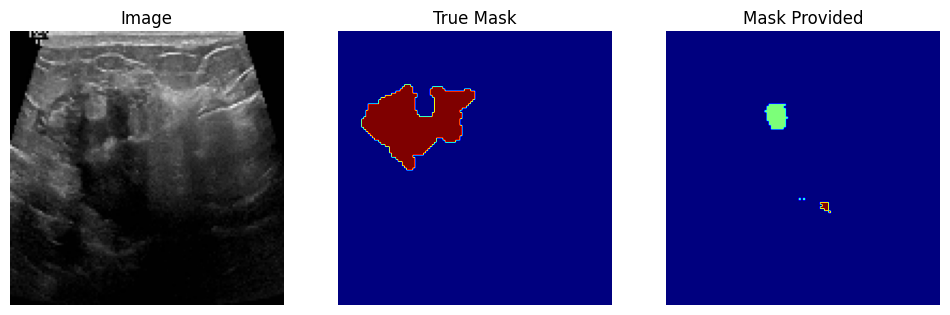

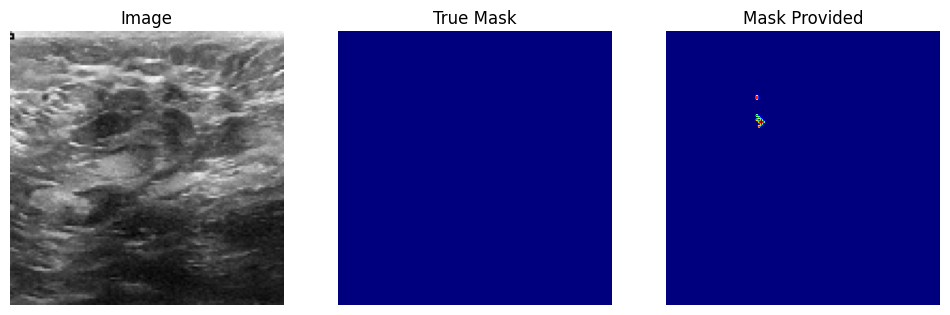

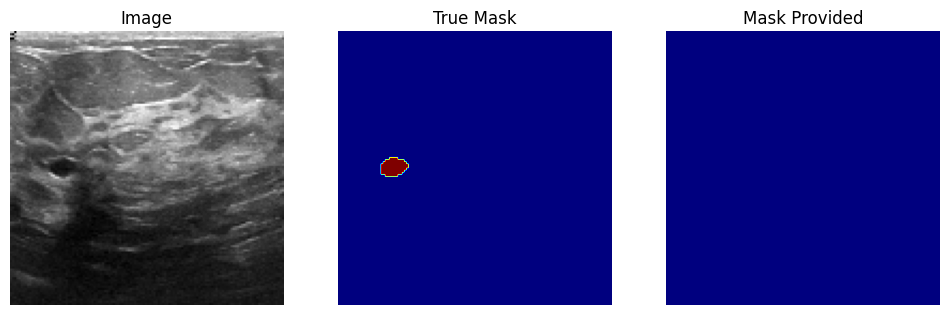

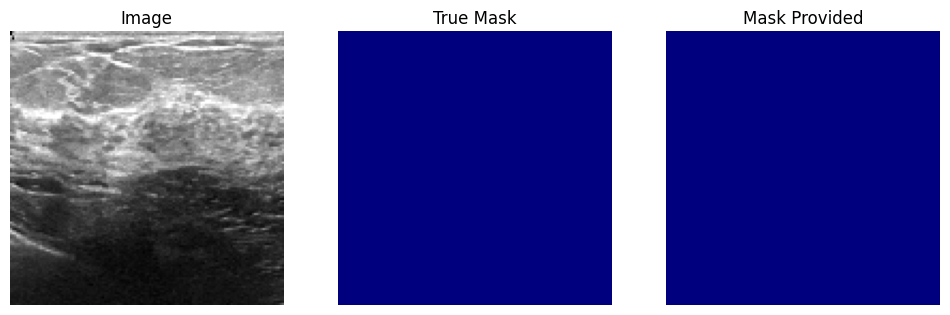

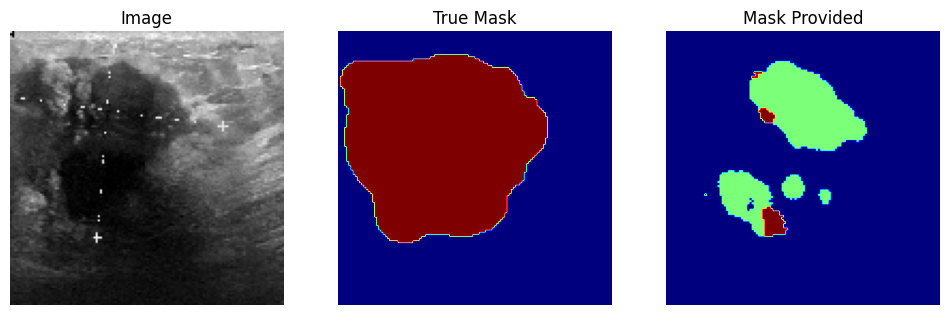

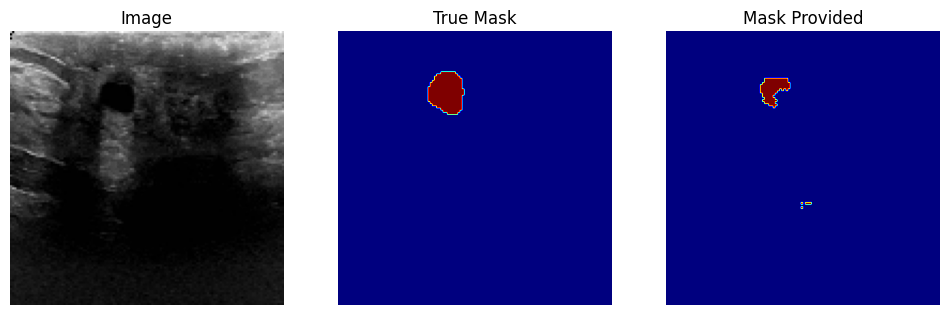

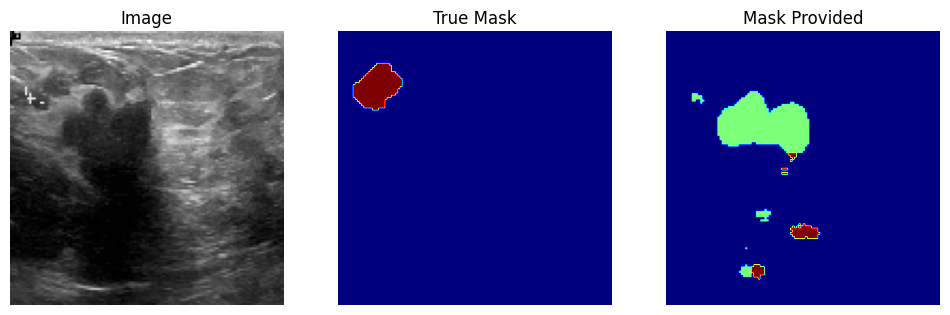

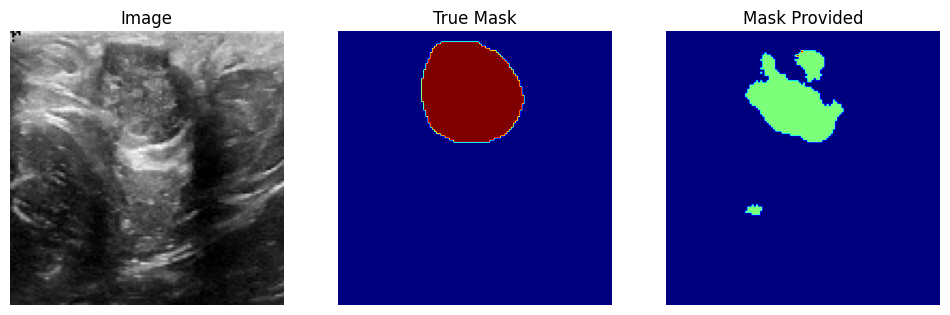

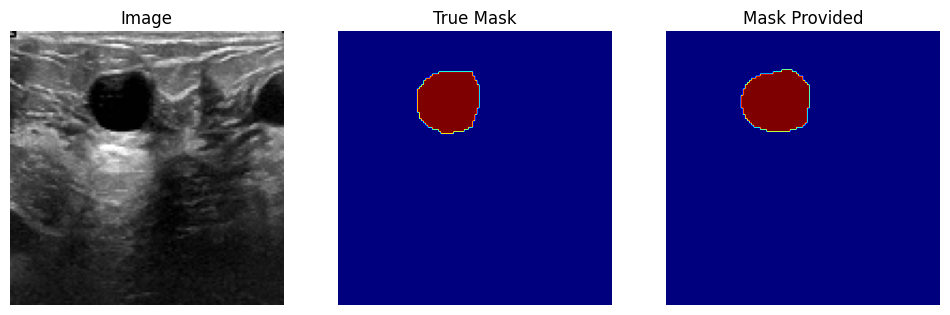

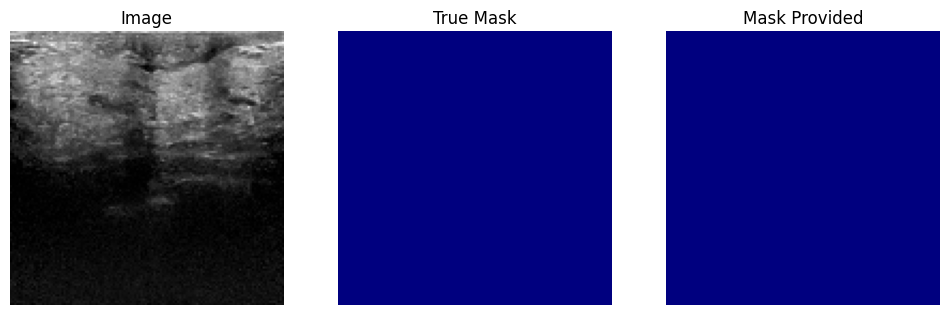

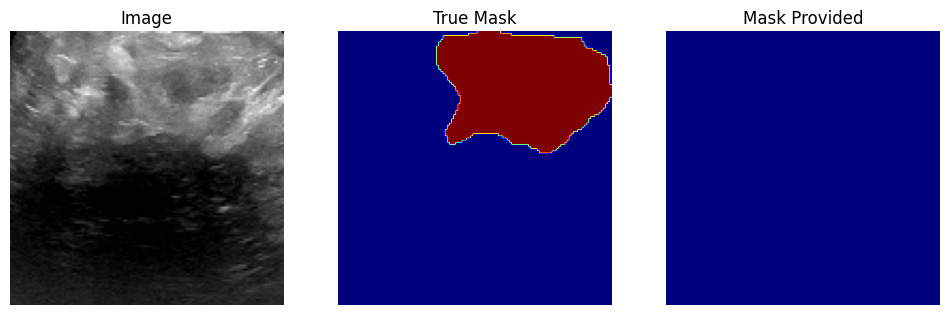

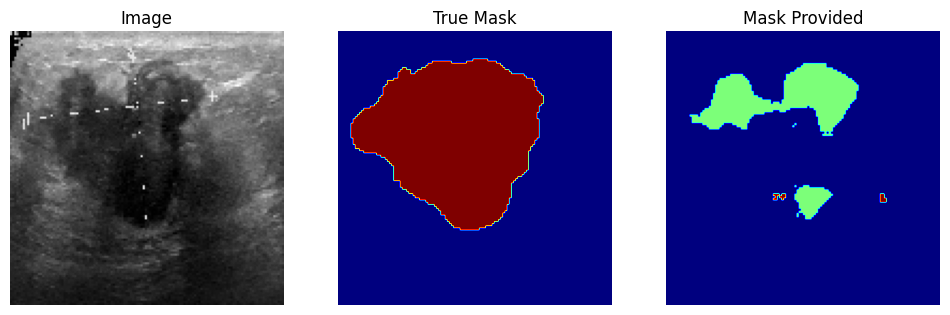

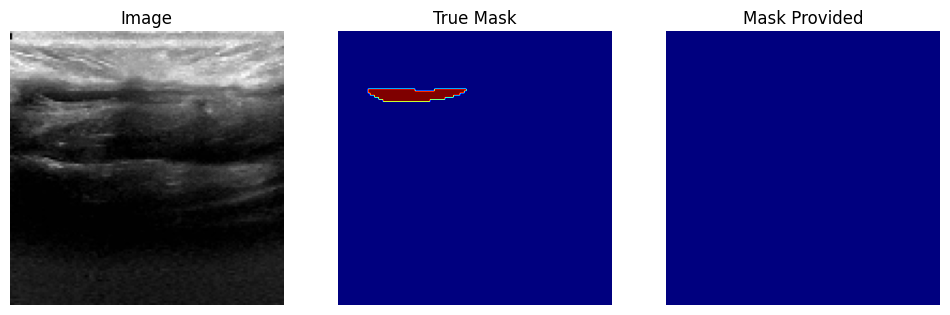

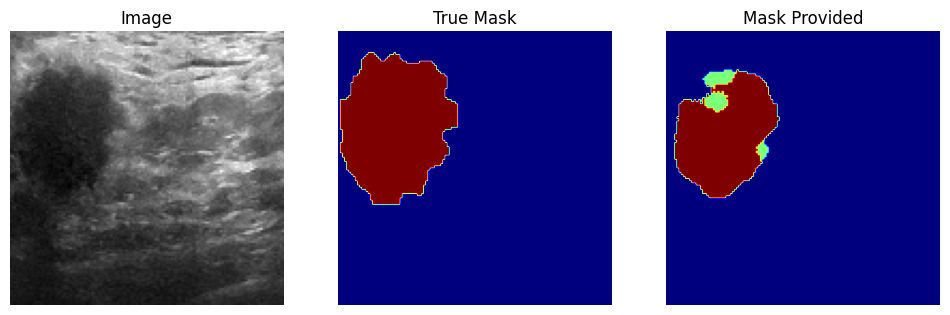

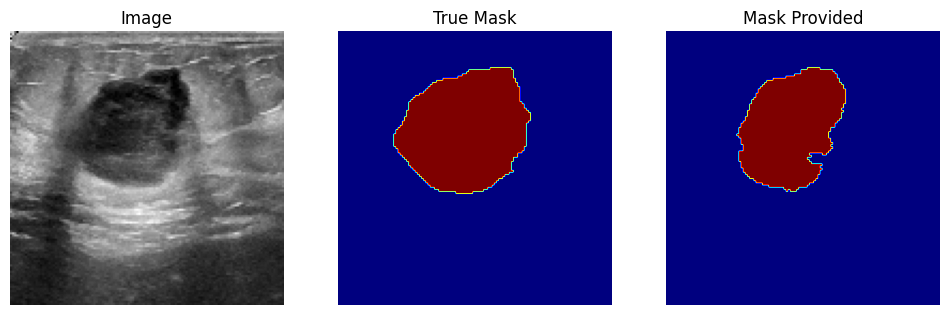

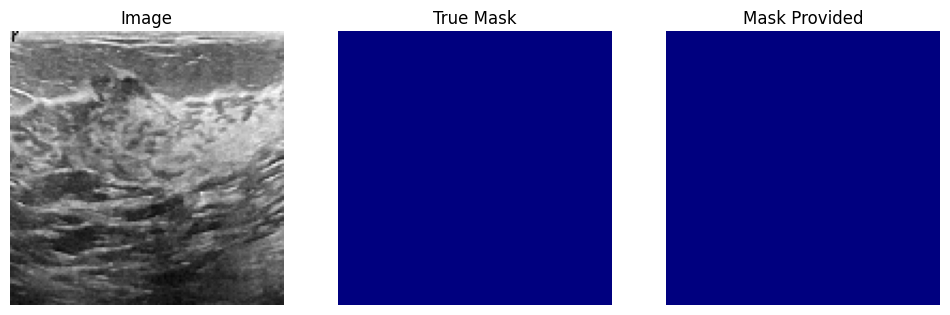

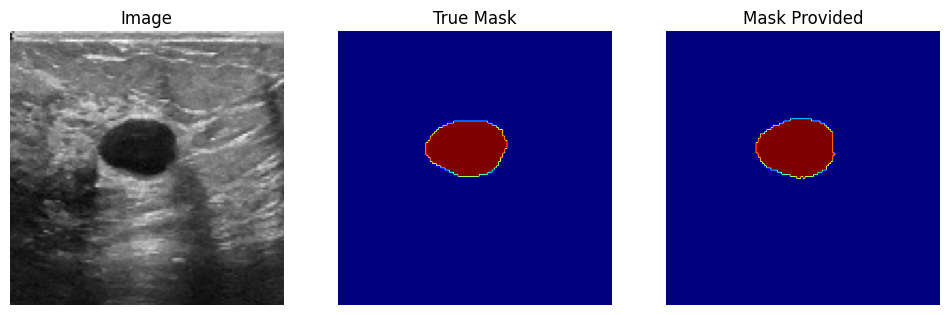

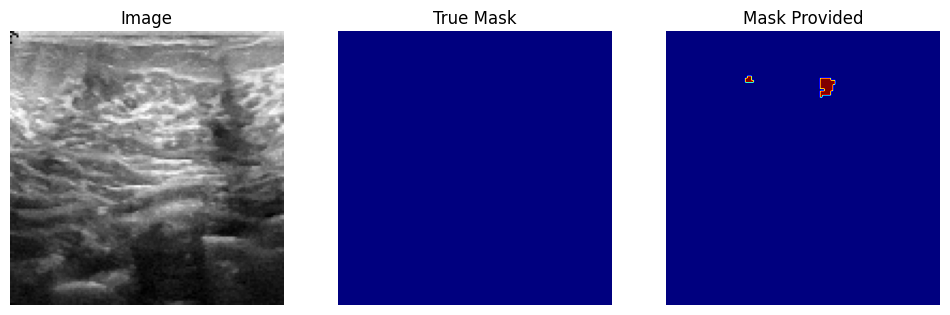

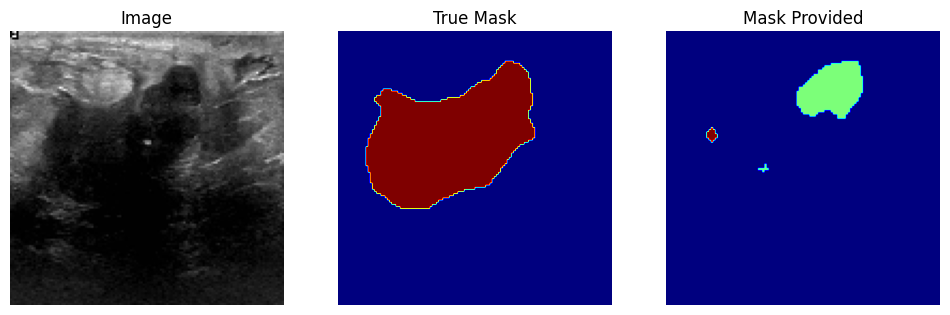

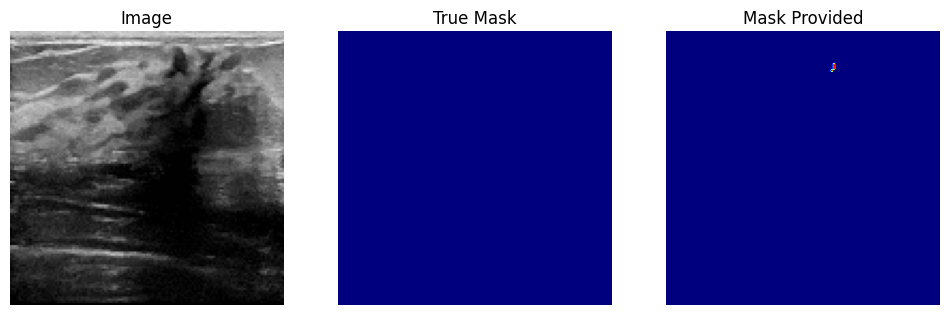

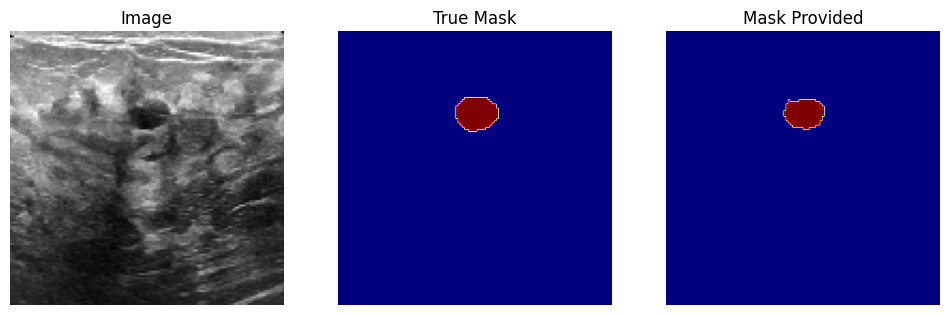

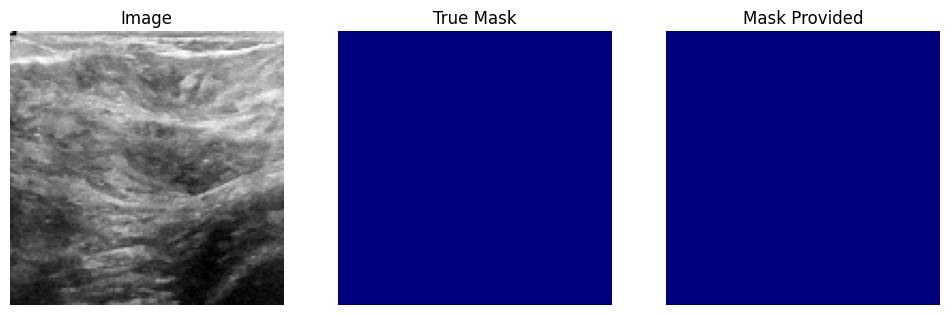

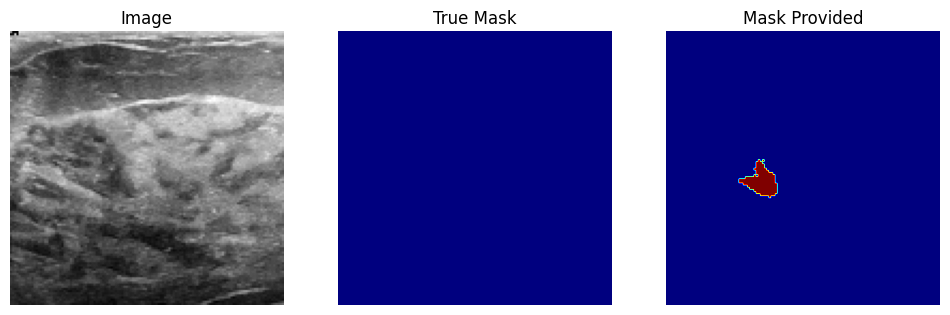

In [19]:
def visualize_predictions(model, data_loader):
    model.eval()
    with torch.no_grad():
        for images_batch, masks_batch in data_loader:
            images_batch = images_batch
            outputs = model(images_batch)
            pred_masks = torch.argmax(outputs, dim=1).numpy()
            
            for i in range(3):  # Візуалізація 3 зображень
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow(images_batch[i].squeeze(), cmap="gray")
                plt.axis("off")
                
                plt.subplot(1, 3, 2)
                plt.title("True Mask")
                plt.imshow(torch.argmax(masks_batch[i], dim=0), cmap="jet")
                plt.axis("off")
                
                plt.subplot(1, 3, 3)
                plt.title("Mask Provided")
                plt.imshow(pred_masks[i], cmap="jet")
                plt.axis("off")
                
                plt.show()

visualize_predictions(model, val_loader)